Imports

In [1]:
import numpy as np
import os

os.environ["OPENCV_LOG_LEVEL"] = "SILENT"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
import cv2

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from keras import layers
from Segmentation_classification.utils.pconv_layer import PConv2D
# from keras.src import backend
# backend.update
from keras.applications.efficientnet_v2 import EfficientNetV2B0
from livelossplot import PlotLossesKeras
import pandas as pd
import numpy as np

from dvclive import Live
from dvclive.keras import DVCLiveCallback

2023-11-20 10:48:30.913936: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-20 10:48:30.913985: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-20 10:48:30.914010: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Preprocessing

In [2]:
cv2.setNumThreads(cv2.getNumThreads())

def extract(mode='train', dim=256):

    def gen_mask(polygon_coords):
        width, height = dim, dim
        # image = np.zeros((height, width), dtype=np.uint8)

        # Create a polygon mask
        polygon_mask = np.zeros((height, width), dtype=np.int32)
        for val, coord in enumerate(polygon_coords, 1):
            cv2.fillPoly(polygon_mask, [coord], val)
        return polygon_mask

    def preproc_polycoord(coord):  # convert and reshape float coordinates into int
        poly_coord_ = np.array(coord).reshape((-1, 2))  # reshape to (x, y)
        # convert coordinates range in (0-1) to image shape ie 256
        poly_coord_ *= dim
        poly_coord_ = np.round(poly_coord_).astype('int32')
        return poly_coord_

    X, Y1, Y2 = [], [], []
    count = 0
    for file in os.scandir(f'dataset/fullteeth/{mode}/labels'):
        with open(file.path, 'r') as dt:
            text = dt.read()

        if len(np_txt := text.split('\n')) == 2:
            cls_txt = [int(np.fromstring(i, sep=' ')[0]) for i in np_txt]
            np_txt = [np.fromstring(i, sep=' ')[1:] for i in np_txt]
        else:
            continue

        poly_coord = [preproc_polycoord(i) for i in np_txt]
        mask_img = gen_mask(poly_coord)
        # plt.imshow(mask_img , cmap='gray')
        # plt.show()

        img = cv2.imread(file.path.replace(
            'labels', 'images').split('.')[0]+'.jpeg')

        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (dim, dim))
            X.append(img)
            Y1.append(mask_img)
            Y2.append(cls_txt)
            count += 1
        elif count > 100000:
            break
        else:
            continue
    
    Y2 = np.array(Y2)
    return np.array(X).astype(np.int32), np.array(Y1), Y2[:, 0], Y2[:, 1]

dim= 512
X_train, Y_train1, Y_train2, Y_train3 = extract(dim=dim)
# X_test, Y_test1, Y_test2, Y_test3 = extract(mode='test', dim=dim)
X_val, Y_val1, Y_val2, Y_val3 = extract(mode='validate', dim=dim)

Invalid SOS parameters for sequential JPEG


Segmentation & Classification

In [3]:
class SegmentImg(layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, inputs):
        x_img_, y_, segment_region = inputs

        x_img_ = tf.cast(x_img_, dtype=tf.int32)
        y_ = tf.cast(y_, dtype=tf.int32)
        segment_region = tf.cast(segment_region, dtype=tf.int32)

        mask = tf.where(tf.logical_or(tf.equal(y_, 0),
                        tf.equal(y_, segment_region)))
        mask_shape = tf.shape(mask)
        mask_shape = tf.tensor_scatter_nd_update(mask_shape, [[1]], updates =[3])
        update = tf.fill(mask_shape, 0)
        # mask_update = tf.tile(tf.expand_dims(update, axis=-1), [1, 3])
        return tf.tensor_scatter_nd_update(x_img_, mask, updates=update)
dim = 512
class MyByte(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.base_model = EfficientNetV2B0(include_top=False, input_shape=(
            dim, dim, 3), include_preprocessing=False)
        # Block 1
        self.upsamp_1 = layers.UpSampling2D((2, 2))
        self.conv_1 = layers.Conv2DTranspose(
            1280, (2, 2), padding='same', activation='relu')
        self.conv_2 = layers.Conv2DTranspose(
            1280, (2, 2), padding='same', activation='relu')
        # Block 2
        self.upsamp_2 = layers.UpSampling2D((2, 2))
        self.conv_3 = layers.Conv2DTranspose(
            640, (2, 2), padding='same', activation='relu')
        self.conv_4 = layers.Conv2DTranspose(
            640, (2, 2), padding='same', activation='relu')
        self.conv_5 = layers.Conv2DTranspose(
            640, (2, 2), padding='same', activation='relu')
        # Block 3
        self.upsamp_3 = layers.UpSampling2D((2, 2))
        self.conv_6 = layers.Conv2DTranspose(
            512, (2, 2), padding='same', activation='relu')
        self.conv_7 = layers.Conv2DTranspose(
            512, (2, 2), padding='same', activation='relu')
        self.conv_8 = layers.Conv2DTranspose(
            512, (2, 2), padding='same', activation='relu')
        self.conv_9 = layers.Conv2DTranspose(
            512, (2, 2), padding='same', activation='relu')
        # Block 4
        self.upsamp_4 = layers.UpSampling2D((2, 2))
        self.conv_10 = layers.Conv2DTranspose(
            512, (2, 2), padding='same', activation='relu')
        self.conv_11 = layers.Conv2DTranspose(
            512, (2, 2), padding='same', activation='relu')
        self.conv_12 = layers.Conv2DTranspose(
            512, (2, 2), padding='same', activation='relu')
        self.conv_13 = layers.Conv2DTranspose(
            512, (2, 2), padding='same', activation='relu')
        self.conv_14 = layers.Conv2DTranspose(
            512, (2, 2), padding='same', activation='relu')
        # Block 5
        self.upsamp_5 = layers.UpSampling2D((2, 2))
        self.conv_15 = layers.Conv2DTranspose(
            512, (2, 2), padding='same', activation='relu')
        self.conv_16 = layers.Conv2DTranspose(
            512, (2, 2), padding='same', activation='relu')
        self.conv_17 = layers.Conv2DTranspose(
            512, (2, 2), padding='same', activation='relu')
        self.conv_18 = layers.Conv2DTranspose(
            512, (2, 2), padding='same', activation='relu')
        self.conv_19 = layers.Conv2DTranspose(
            512, (2, 2), padding='same', activation='relu')
        self.conv_20 = layers.Conv2DTranspose(
            512, (2, 2), padding='same', activation='relu')
        self.conv_21 = layers.Conv2DTranspose(
            3, (1, 1), activation='softmax')
        
        # Segmentating input image based on predicted masked image
        self.segment_img = SegmentImg()
        # argmax of segmentation and masking
        self.lambdaa = layers.Lambda(lambda u: tf.argmax(u, axis=3))
        self.masking_layer = layers.Masking(mask_value=0, input_shape=(3,))
        # Classification
        self.classification_model1 = EfficientNetV2B0(
            include_top=False, input_shape=(dim, dim, 3), include_preprocessing=False)
        self.classification_model2 = EfficientNetV2B0(
            include_top=False, input_shape=(dim, dim, 3), include_preprocessing=False)
        # pooling
        self.dropout = layers.Dropout(0.5)
        self.avg_pooling1 = layers.GlobalAveragePooling2D()
        self.avg_pooling2 = layers.GlobalAveragePooling2D()
        self.dense1 = layers.Dense(256, activation='relu')
        self.dense2 = layers.Dense(256, activation='relu')
        self.denseout1 = layers.Dense(4, activation='softmax')
        self.denseout2 = layers.Dense(4, activation='softmax')

    def call(self, inputs, training=True, mask=None):

        if training:
            x_img, y = inputs
        else:
            x_img = inputs

        x = self.base_model(x_img)
        x = self.upsamp_1(x)
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.upsamp_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.conv_5(x)
        x = self.upsamp_3(x)
        x = self.conv_6(x)
        x = self.conv_7(x)
        x = self.conv_8(x)
        x = self.conv_9(x)
        x = self.upsamp_4(x)
        x = self.conv_10(x)
        x = self.conv_11(x)
        x = self.conv_12(x)
        x = self.conv_13(x)
        x = self.conv_14(x)
        x = self.upsamp_5(x)
        x = self.conv_15(x)
        x = self.conv_16(x)
        x = self.conv_17(x)
        x = self.conv_18(x)
        x = self.conv_19(x)
        x = self.conv_20(x)
        segmentation_output = self.conv_21(x)


        if training:
            masked_img1 = self.segment_img([x_img, y, 2])
            masked_img2 = self.segment_img([x_img, y, 1])

            clss1 = self.masking_layer(masked_img1)
            clss1 = self.classification_model1(clss1)
            clss1 = self.avg_pooling1(clss1)
            # clss1 = self.dropout(clss1)
            clss1 = self.dense1(clss1)
            output1 = self.denseout1(clss1)

            clss2 = self.masking_layer(masked_img2)
            clss2 = self.classification_model2(clss2)
            clss2 = self.avg_pooling2(clss2)
            # clss2 = self.dropout(clss2)
            clss2 = self.dense2(clss2)
            output2 = self.denseout2(clss2)

        else:
            y_mask = self.lambdaa(segmentation_output)
            masked_img1 = self.segment_img([x_img, y_mask, 2])
            masked_img2 = self.segment_img([x_img, y_mask, 1])

            clss1 = self.masking_layer(masked_img1)
            clss1 = self.classification_model1(clss1)
            clss1 = self.avg_pooling1(clss1)
            # clss1 = self.dropout(clss1)
            clss1 = self.dense1(clss1)
            output1 = self.denseout1(clss1)

            clss2 = self.masking_layer(masked_img2)
            clss2 = self.classification_model2(clss2)
            clss2 = self.avg_pooling2(clss2)
            # clss2 = self.dropout(clss2)
            clss2 = self.dense2(clss2)
            output2 = self.denseout2(clss2)

        return [segmentation_output, output1, output2]
        # return [output1, output2]


# Create an instance of your custom model
model = MyByte()
model.output_names=['seg', 'clss1', 'clss2']

Training

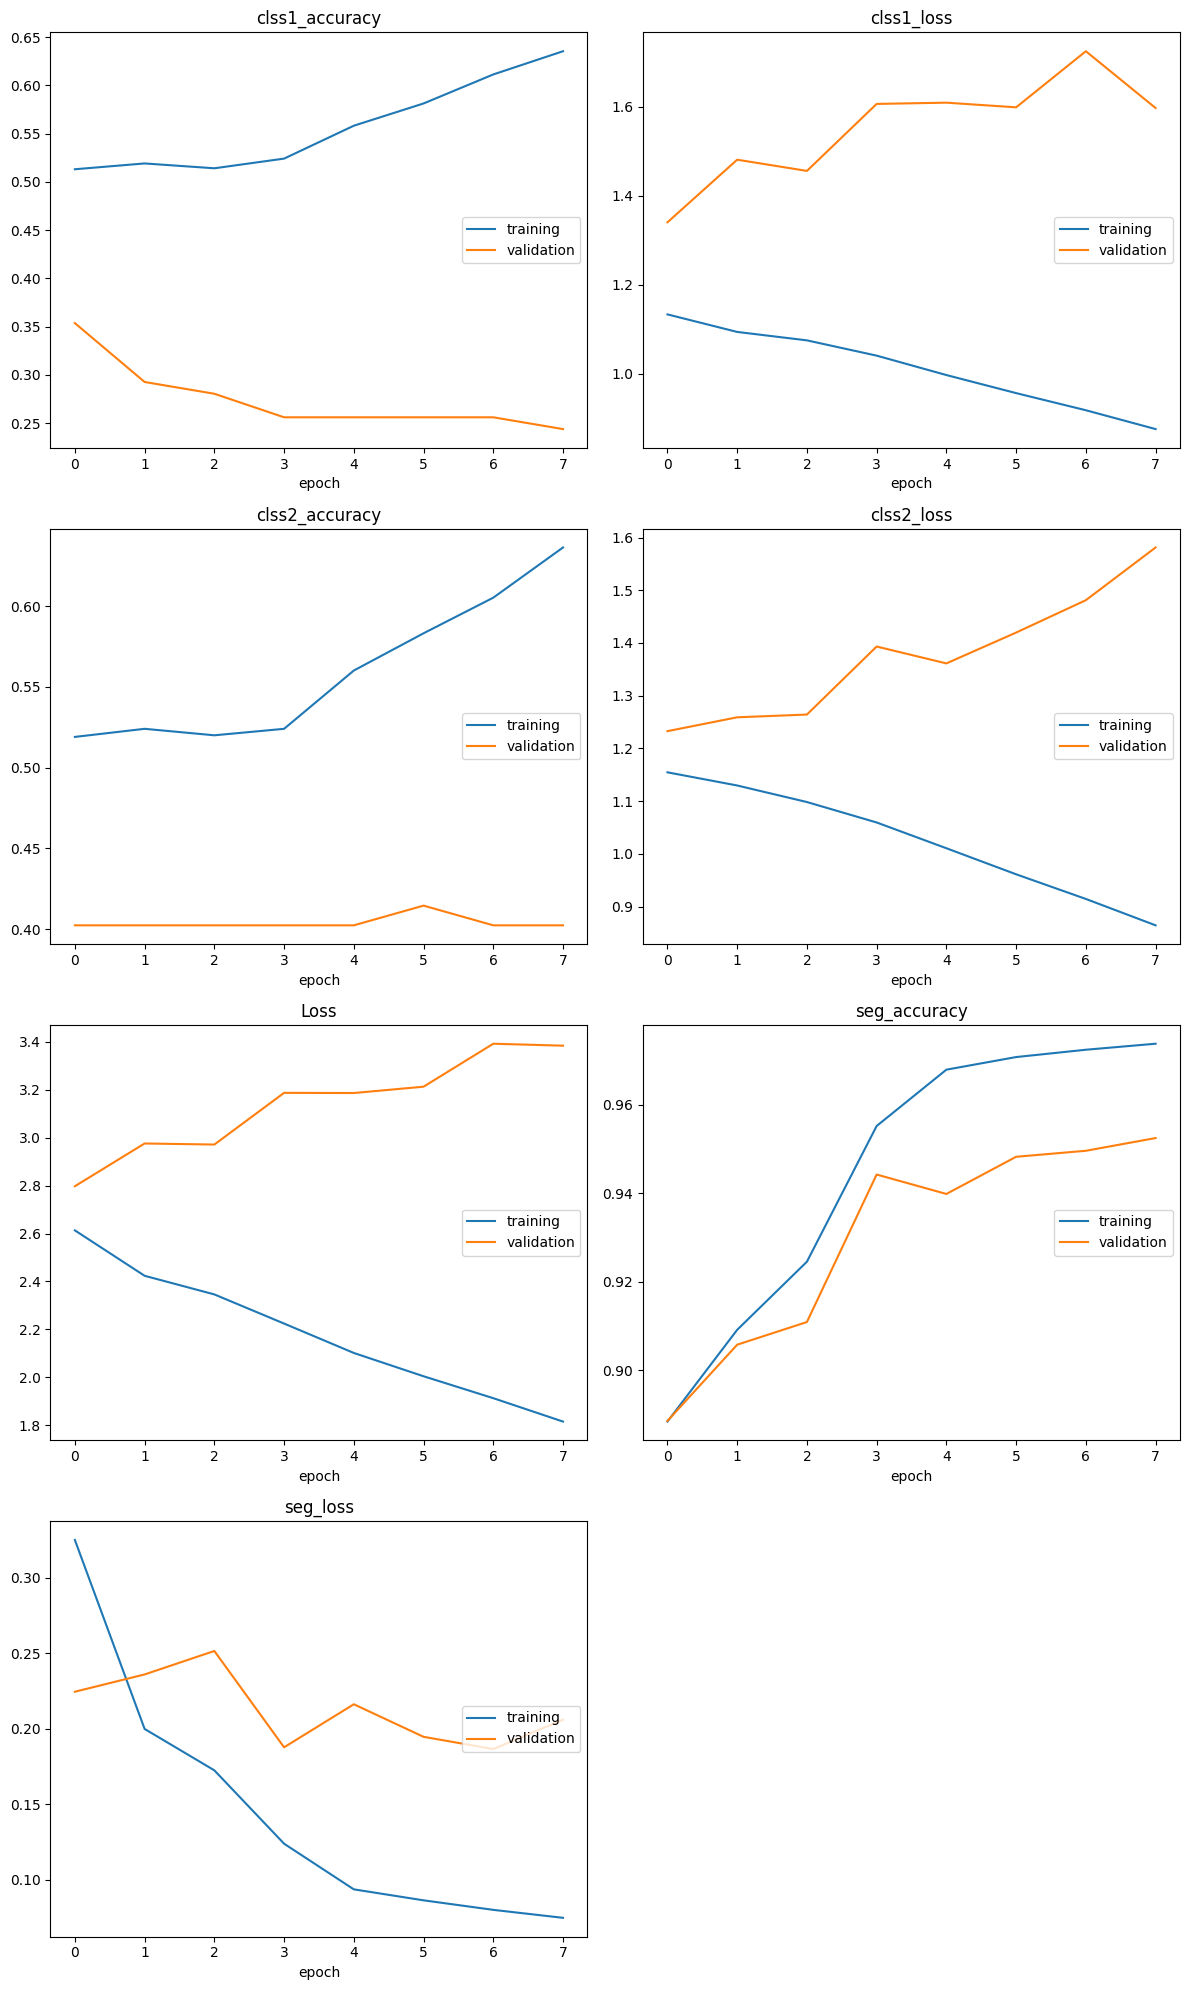

clss1_accuracy
	training         	 (min:    0.513, max:    0.635, cur:    0.635)
	validation       	 (min:    0.244, max:    0.354, cur:    0.244)
clss1_loss
	training         	 (min:    0.876, max:    1.134, cur:    0.876)
	validation       	 (min:    1.340, max:    1.725, cur:    1.597)
clss2_accuracy
	training         	 (min:    0.519, max:    0.636, cur:    0.636)
	validation       	 (min:    0.402, max:    0.415, cur:    0.402)
clss2_loss
	training         	 (min:    0.864, max:    1.155, cur:    0.864)
	validation       	 (min:    1.233, max:    1.581, cur:    1.581)
Loss
	training         	 (min:    1.815, max:    2.613, cur:    1.815)
	validation       	 (min:    2.797, max:    3.392, cur:    3.384)
seg_accuracy
	training         	 (min:    0.888, max:    0.974, cur:    0.974)
	validation       	 (min:    0.889, max:    0.952, cur:    0.952)
seg_loss
	training         	 (min:    0.075, max:    0.325, cur:    0.075)
	validation       	 (min:    0.186, max:    0.251, cur:    0.20

	PartialConv.ipynb, segmentation_classification_markdown.py, segmentation_classification.ipynb


KeyboardInterrupt: 

In [4]:
dim="512"
batch_size = 1
model.compile(optimizer=tf.optimizers.RMSprop(learning_rate=0.00001),
              loss={'seg': 'sparse_categorical_crossentropy', 'clss1': 'sparse_categorical_crossentropy',
                    'clss2': 'sparse_categorical_crossentropy'},
              metrics={'seg': 'accuracy', 'clss1': 'accuracy', 'clss2': 'accuracy'})
with Live() as live:
      model.fit([X_train, Y_train1], {'seg': Y_train1, 'clss1': Y_train2, 'clss2': Y_train3}, batch_size=batch_size, epochs=50, verbose=1,
          validation_data=(X_val, [Y_val1, Y_val2, Y_val3]), validation_batch_size=batch_size,
          callbacks=[PlotLossesKeras(), DVCLiveCallback(live=live)])

      model.save("512model.keras")
      live.log_artifact("512model.keras", type="512model")
# loss, accuracy = model.evaluate(X_test, [Y_test1, Y_test2, Y_test3])
# error = 197871

In [ ]:
model.summary()
hist_df = pd.DataFrame(model.history.history)
hist_df.to_csv('512model.csv', index=False)
# model.save("seg_clss_iter1.keras")

In [ ]:
# model = tf.keras.models.load_model('segmentation.tf')
img = cv2.imread(
    "fullteeth/test/images/0015w00002NZScQAAX_4dff1fe0-4fc1-11eb-9072-8fb3c6ce79ed-checkinsmileon-1687979590788.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_res = cv2.resize(img, (256, 256)).reshape((1, 256, 256, 3))
# pred = model.predict(img_res)

In [ ]:
img.dtype

In [ ]:
import matplotlib.pyplot as plt

pred_img = np.argmax(pred, 3).reshape((256, 256))
plt.imshow(img_res.reshape((256, 256, 3)))
plt.show()
plt.imshow(pred_img.astype(np.uint))
plt.show()

In [ ]:
import matplotlib.pyplot as plt
resized_img = np.copy(img_res)
contours, _ = cv2.findContours(pred_img.astype(
    np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)

# Convert the contour to a list of polygon coordinates
polygon_coords = largest_contour.reshape(-1, 2)
# Optionally, you can round the coordinates to integer values
polygon_coords = np.round(polygon_coords).astype(int)
# Print or use the polygon coordinates
print("Polygon Coordinates:")
cv2.drawContours(resized_img, [polygon_coords], -1,
                 (255, 255, 255), thickness=cv2.FILLED)
plt.imshow(resized_img)
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)